# 環境設定

## 載入所需的函式庫

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

## 載入 MNIST 資料集

* Autoencoder 屬於「自監督學習」（Self-supervised Learning）。
* 它透過比對「輸入值」與「生成值」來計算模型效能。因此不需要 Y_train 與 Y_test。

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, _), (X_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# 前處理

## 正規化與展平圖片

In [ ]:
# 將 0~255 正規化為 0~1 之間
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# 展平圖片
# len(X_train) 會計算 X_train 有幾筆資料。以 X_train.shape = (60000, 28, 28) 來說，len(X_train) 就是 60000。
# X_train.shape[1:] 會取 X_train 索引值 1 以後的所有維度。本例為 (28, 28)
# np.prod() 將當前陣列內的元素，全部相乘。本例為 28x28 = 784
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

## 添加隨機雜訊

In [ ]:
# 選擇添加 50% 的雜訊到原圖上
noise_factor = 0.5

# 將原圖加上雜訊
# np.random.normal()：會從常態分佈中，取樣一個亂數出來
# loc=0.0 : 用來指定這個常態分佈的 μ=0.0
# scale=1.0 : 用來指定這個常態分佈的 σ=1.0
# size=X_train.shape : 用來指定要產生一個二維陣列 (60000, 784) 的亂數
# 此時 X 每個元素的數值，將會是「原值 + 0.5 * (-1.0, 1.0)」= 「原值 + (-0.5, 0.5)」
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# np.clip() 可以把數字裁剪限制在某個範圍內
# 低於 0 的當成 0, 高於 1 的當成 1
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# 建立 Denoise Autoencoder 模型

* Autoencoder 通常用於重構輸入數據，而不是進行傳統意義上的分類或回歸任務。
* 在 Autoencoder 的案例中，我們通常關注的是重構誤差，這通常通過損失函數（如均方誤差或二元交叉熵）來衡量。
* 因此，在編譯 Autoencoder 時，一般不會指定任何 metrics 參數。
* 不過，如果您想要更詳細地監控模型的訓練過程，您可以添加均方誤差（MSE）指標。

In [ ]:
# 輸入層：一維 784 個節點
input_img = Input(shape=(784,))

# 編碼層：一維 128 個節點
encoded = Dense(128, activation='relu')(input_img)

# 解碼層：一維 784 個節點
decoded = Dense(784, activation='sigmoid')(encoded)

# 將「頭尾」丟給 Model，做為「自變數 vs. 應變數」，請它合成整個模型
autoencoder = Model(input_img, decoded)

 # 編譯模型
 # 由於是輸入層 784 像點 vs. 輸出層 784 像點對比，只有「相同」與「不同」兩種可能，因此使用「二元交叉熵」當損失函數
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=["mse"])

# 訓練模型

* autoencoder = Model(input_img, decoded) 要求使用時，需給定自變數與應變數。
* X_train_noisy 就是 input_img，做為自變數。
* X_train 就是 decode，做為應變數（正確答案）。
* shuffle=True: 訓練前將資料集順序打亂，避免模型學到特定順序

In [ ]:
autoencoder.fit(X_train_noisy, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

Epoch 1/100
235/235 [==============================] - 9s 6ms/step - loss: 0.2350 - mse: 0.0562 - val_loss: 0.1684 - val_mse: 0.0341
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1530 - mse: 0.0290 - val_loss: 0.1394 - val_mse: 0.0247
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1342 - mse: 0.0229 - val_loss: 0.1279 - val_mse: 0.0209
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1258 - mse: 0.0202 - val_loss: 0.1222 - val_mse: 0.0191
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1209 - mse: 0.0186 - val_loss: 0.1184 - val_mse: 0.0179
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1177 - mse: 0.0176 - val_loss: 0.1159 - val_mse: 0.0171
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1154 - mse: 0.0169 - val_loss: 0.1143 - val_mse: 0.0166
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - 

# 預測與驗證其正確性

## 使用 Autoencoder 重構無雜訊圖像

In [ ]:
decoded_imgs = autoencoder.predict(X_test_noisy)

313/313 [==============================] - 1s 2ms/step


# 顯示前十個圖片以驗證正確性

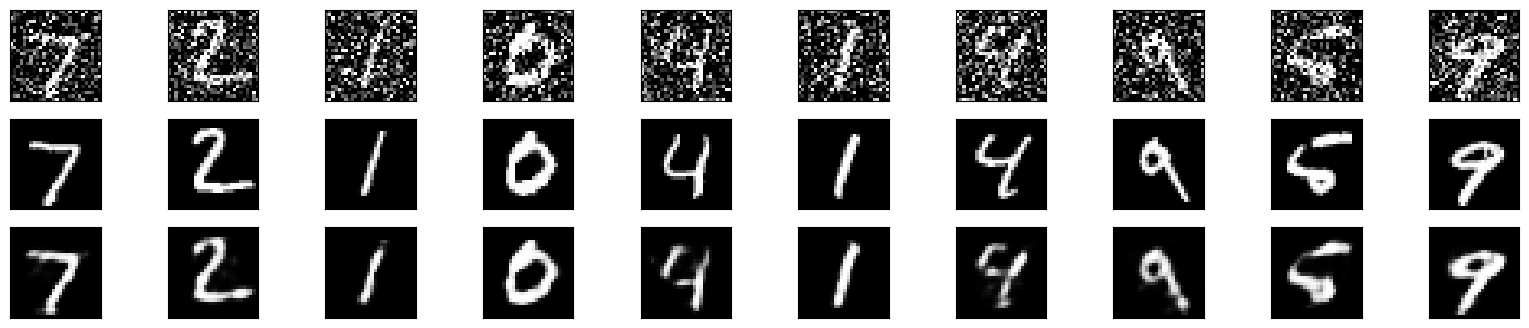

In [ ]:
n = 10  # 顯示幾張圖片
plt.figure(figsize=(20, 4)) # 建立寬度為 20 英寸、高度為 4 英寸的繪圖窗口
for i in range(n):
    # 帶噪聲的輸入圖像
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()  # 確保待會兒 plt.show() 時，圖像以灰階顯示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 原始圖像
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()  # 確保待會兒 plt.show() 時，圖像以灰階顯示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 重構圖像
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()  # 確保待會兒 plt.show() 時，圖像以灰階顯示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()